#### Robotics - Assignment - 1
Name: Abdelrahman Mohammed Abdelfattah
<br/>Sec : 1
<br/>BN  : 23
<br/><br/>

#### Output Format
##### Requirement 1
See outputs/ray1_ray_casting.png<br/>
<br/>
<br/>

##### Requirement 2
Each Sigma value will have a (likelihood, prop, prop_masked) tuple<br/>
<b>likelihood</b>: is the likelihood field (gray-scale encoded) of the map given a specific sigma value.<br/>
<b>prop</b>: is the probability map (gray-scale encoded) of the robot location for a given sigma for the likelihood field.<br/>
<b>prop_masked</b>: same as <code>prop</code> but I masked the map into it for better perspective. the more blue the pixel is the more likely it is to be the robot location.<br/>
<br/>
All of these outputs are stored inside the /outputs folder, with the following formating:<br/>
<b>likelihood</b>: likelihood_sigma={sigma_value}.png<br/>
<b>prop</b>: prop_sigma={sigma_value}.png<br/>
<b>prop_masked</b>: prop_sigma={sigma_value}_masked.png<br/>

In [1]:
# libraries used in the project :)
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import sys


# define some useful classes
class SensorReading:
    def __init__(self, distance, value):
        self.distance = distance
        self.value = value



## GPU Acceleration
You can either run this cell or not depending on your preference (I recommend running it)
I wrote the code for the likelihood estimation to work on GPU and CPU, to be honest with you
at first I wrote it only for CPU, but it was too slow to the point where I wrote the GPU code
and tested it, and it still finished before the CPU code give me even one image XD.
<br/>
<br/>
<b>This cell loads torch Library to use CUDA for GPU execution.</b>

In [2]:
# DON'T RUN THIS CELL IF YOU DON'T HAVE touch and CUDA installed
# just skip it the code will adapt :)
import torch
print(f"CUDA supported: {torch.cuda.is_available()}")
CUDA_DEVICE_NUMBER = 0   # Mine was 0, make sure yours is correct from the output of this cell :)
print(torch.cuda.get_device_name(CUDA_DEVICE_NUMBER))

# if CUDA isn't available it will run on CPU regardless

CUDA supported: True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Image loading
we load the initial map into the <code>map_image</code> variable.

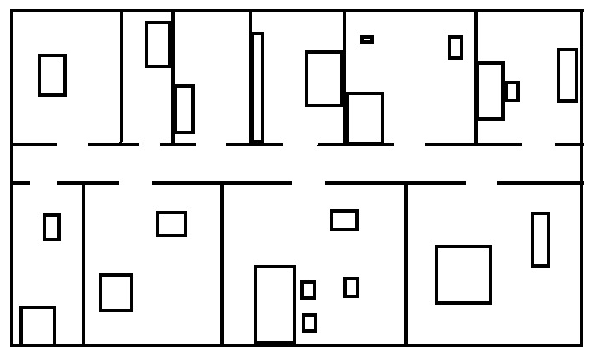

In [3]:
# Image loading
map_image = cv2.imread('Map.jpg')

if map_image is None:
    raise Exception('Map image not found')

map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)


io.imshow(map_image)
plt.axis("off")
plt.show()

## Robot Configuration
we define some variables for the robot here

In [4]:
look_angle = 200               # the direction the robot is looking at wrt X-Axis
opening_angle = 250            # opening angle of the robot
ray_resolution = 2             # step 2 degs between each two rays
ray_range = 1200 / 4           # 1200 cm / 4 cm -> meter to pixels
robot_size = 10                # in pixels
robot_position = (350, 185)    # in pixels
readings: [SensorReading] = []

## Requirement 1
Simply shoot some rays from the robot location <b>(350, 185)</b> and angle <b>210</b> until it hit a wall,<br/> then draw an image that contains these rays

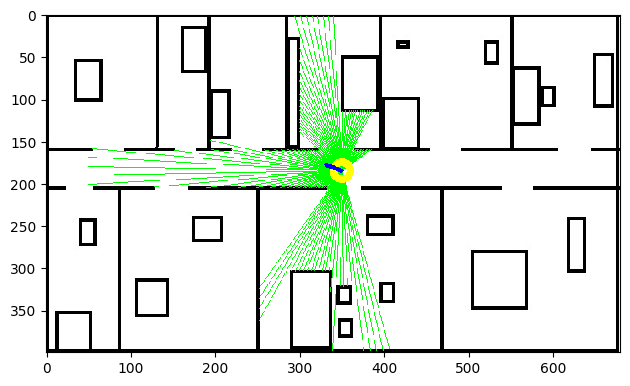

True

In [5]:
# Requirement 1
def rayCast(image, x, y, ray_range, angle):
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = image

    # Precompute angle in radians
    angle_rad = np.deg2rad(angle)

    # Initialize end point variables
    end_x = int(x + int(round(ray_range * np.cos(angle_rad))))
    end_y = int(y + int(round(ray_range * np.sin(angle_rad))))

    # Ray-cast along the line
    for r in range(1, int(ray_range) + 1):
        # Calculate the next point along the line
        dx = int(round(r * np.cos(angle_rad)))
        dy = int(round(r * np.sin(angle_rad)))
        
        px, py = int(x + dx), int(y + dy)
        
        # Check if the point is within image bounds
        if 0 <= px < grayscale.shape[1] and 0 <= py < grayscale.shape[0]:
            # Check if the pixel is black
            if grayscale[int(py), int(px)] == 0:
                return px, py
        else:
            # Stop searching if outside bounds
            return int(round((r - 1) * np.cos(angle_rad))), int(round((r - 1) * np.sin(angle_rad)))

    # No intersection found, return the end point
    return end_x, end_y


map_copy = map_image.copy()
grayscale = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)

for x in range(0, opening_angle + 1, ray_resolution):
    angle = look_angle - x + opening_angle / 2
    end_x, end_y = rayCast(grayscale, robot_position[0], robot_position[1], ray_range, angle)
    cv2.line(map_copy, (int(robot_position[0]), int(robot_position[1])), (end_x, end_y), (0, 255, 0), 1)
    
    distance = ((end_x - robot_position[0])**2 + (end_y - robot_position[1])**2)**0.5
    reading = (255 - grayscale[end_y][end_x]) / 255
    
    readings.append(SensorReading(distance , reading))

end_x, end_y = rayCast(map_image, robot_position[0], robot_position[1], robot_size * 2, look_angle)
cv2.circle(map_copy, (int(robot_position[0]), int(robot_position[1])), robot_size, (255, 255, 0), 8)
cv2.line(map_copy, (int(robot_position[0]), int(robot_position[1])), (end_x, end_y), (0, 0, 255), 4)

io.imshow(map_copy)
plt.show()

cv2.imwrite('outputs/req1_ray_casting.png', map_copy)


## Requirement 2
based on the readings we obtained from 1, we now try to estimate where the robot is on the map <br/>
We simply do:
<ul>
<li> Create Likelihood map for end-point sensor modal </li>
<li> For each point in our map, we calculate the probablity that this is the point we obtained the reading from </li>
<li> When we calculate the probablity we assume independance of the readings</li>
</ul>

doing this for all points on the map with all orientations, we get a new "probability image" that tells us where <br/> 
the robot might be. 

<i>please note that the code is divided into two sections: cpu & gpu, both implements the same logic</i>

In [6]:
# Requirement 2


def compute_likelihood(img, sigma):
    """
    Computes the likelihood field for a given map image and sigma value
    :param img: the map image
    :param sigma: well ... the gaussian sigma value :/
    :return: a gary-scale encoded likelihood field of the map
    """
    
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.astype(np.uint8)
    
    # calculate the distance transform
    distance = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)

    # Compute the likelihood field using a Gaussian function
    # no need to divide by sqrt(2pi) * sigma because we are
    # going to normalize by the max later anyways.
    likelihood_field = np.exp(-0.5 * (distance / sigma) ** 2) 
    
    # Normalize the likelihood field to [0, 1]
    normalized = likelihood_field / np.max(likelihood_field)
    
    return normalized.astype(np.double)

# =============================================================================================================
# ================================================ CPU VERSION ================================================
# =============================================================================================================
def endPoint(x, y, ray_range, angle):
    """
    Computes the end point of a given ray and angle
    :param x: initial x position
    :param y: initial y position
    :param ray_range: ray length
    :param angle: the angle the ray does with the x-axis (degree)
    :return: the position this ray ends
    """
    angle_rad = np.deg2rad(angle)
    end_x = x + ray_range * np.cos(angle_rad)
    end_y = y + ray_range * np.sin(angle_rad)
    return end_x, end_y


def calculate_max_likelihood(likelihood_field, x, y, sensor_readings):
    """
    Calculates the maximum probability that the robot is in this point given a certain sensor readings
    :param likelihood_field: a grayscale encoded likelihood field of the map
    :param x: the test point x position
    :param y: the test point y position
    :param sensor_readings: the robot sensor readings
    :return: the probability that this point is the actual robot location given the readings
    """
    width = likelihood_field.shape[1]
    height = likelihood_field.shape[0]
    
    prop_v = 0
    for angle in range(0, 360): # loop over every angle
        p_k = 1
        for dAngle in range(0, opening_angle + 1, ray_resolution): # check how much does each reading differ
            # calculate this ray angle
            ray_angle = angle - dAngle + opening_angle / 2
            # calculate the end point given the original reading distance
            end_x, end_y = endPoint(x, y, sensor_readings[dAngle // ray_resolution].distance, ray_angle)
            p_x = int(end_x)
            p_y = int(end_y)
            
            if p_x >= width or p_x < 0 or p_y >= height or p_y < 0:
                # penalize points that are out-of-range
                p_k *= 1e-10
            else:
                # if is inside, check the difference between the original reading and the reading we expect
                diff = abs(likelihood_field[p_y, p_x] - sensor_readings[dAngle // ray_resolution].value)
                # convert to a probability using e^-diff
                p_k *= np.exp(-1.0 * diff)
        prop_v = max(prop_v, p_k)
    return prop_v
    
    
def compute_probability_map(likelihood_field, readings, resolution=1):
    """
    Given a likelihood field and some sensors readings. this function returns an image that's
    gray scale encoded with the probability of the robot being at each point
    :param likelihood_field: the likelihood field
    :param readings: the original robot readings
    :param resolution: the resolution of the output (must be at most 1)
    :return: a probability map
    """
    print(f"Sampling with resolution: {resolution} (taking 1 out of each {int(1/resolution)} pixels)")
    
    prop_map = np.zeros(likelihood_field.shape)
    
    last_porg = -1 # a variable to keep track of the current progress 
    for y in range(0, prop_map.shape[0], int(1 / resolution)):
        for x in range(0, prop_map.shape[1], int(1 / resolution)):
            curr = ((x + y * prop_map.shape[1]) / prop_map.shape[0] / prop_map.shape[1]) * 100
            if int(curr) > last_porg:
                last_porg = curr
                print(f"Progress {last_porg:.2f}%")
            
            # iterate over each point, and calculate its max probability to be the robot location
            prop_map[y][x] = calculate_max_likelihood(likelihood_field, x, y, readings)
            
    print(f"Max: {np.max(prop_map)} , at : {np.argmax(prop_map)}")
    return prop_map / np.max(prop_map) # normalize on max


# =============================================================================================================
# ================================================ GPU VERSION ================================================
# =============================================================================================================

# the code here is the same as the GPU version
# I rewrote it so that it works with CUDA and pytorch
# the functionality is exactly the same tho 
# the only variables that you may care about would be:
#     - angle_batch_size

# for each pixel, who many angels do we calculate at once ?
angle_batch_size = 50  # change as you like, I found 50 for angle_batch to be 
                       # decent for 4GB cards
                       
                       
# how many pixels do we process at once ?
# we take a chunk with length equal to batch_size
# so the actual pixel count would be batch_size^2
batch_size = 64        # Reduced batch size for better memory management
                       # 64 works best of a 4GB Card
    
                           
def endPoint_batch(x, y, distances, angles):
    angles_rad = torch.deg2rad(angles)
    end_x = x + distances * torch.cos(angles_rad)
    end_y = y + distances * torch.sin(angles_rad)
    return end_x, end_y


def calculate_max_likelihood_batch(likelihood_field_gpu, x_batch, y_batch, sensor_readings):
    device = likelihood_field_gpu.device
    width = likelihood_field_gpu.shape[1]
    height = likelihood_field_gpu.shape[0]
    batch_size = len(x_batch)
    
    # Create angle tensors on GPU
    angles = torch.arange(0, 360, device=device).float()
    dAngles = torch.arange(0, opening_angle + 1, ray_resolution, device=device).float()
    
    # Convert sensor readings to GPU tensor [n_rays, 2]
    sensor_readings_gpu = torch.tensor(sensor_readings, device=device)
    distances = sensor_readings_gpu[:, 0]  # [n_rays]
    expected_values = sensor_readings_gpu[:, 1]  # [n_rays]
    
    # Initialize results tensor for all positions
    results = torch.zeros(batch_size, device=device)
    
    # Reshape position tensors for broadcasting
    x_batch_reshaped = x_batch.view(-1, 1, 1)  # [batch, 1, 1]
    y_batch_reshaped = y_batch.view(-1, 1, 1)  # [batch, 1, 1]
    
    for angle_start in range(0, 360, angle_batch_size):
        angle_end = min(angle_start + angle_batch_size, 360)
        angle_batch = angles[angle_start:angle_end]  # [angle_batch]
        # print(f"angle_batch.shape = {angle_batch.shape}")
        
        # Calculate angles for all rays in batch
        angle_d = angle_batch.unsqueeze(1) - dAngles + opening_angle / 2  # [angle_batch, n_rays]
        # print(f"angle_d.shape = {angle_d.shape}")
        
        # Reshape angle_d for broadcasting
        # angle_d = angle_d.unsqueeze(0)  # [1, angle_batch, n_rays]
        # print(f"angle_d.shape = {angle_d.shape}")
        
        # Calculate endpoints for all positions and angles
        end_x, end_y = endPoint_batch(
            x_batch_reshaped,  # [batch, 1, 1]
            y_batch_reshaped,  # [batch, 1, 1]
            distances.unsqueeze(0).unsqueeze(0),  # [1, 1, n_rays]
            angle_d  # [1, angle_batch, n_rays]
        )
        
        # print(f"end_x.shape = {end_x.shape}")
        # print(f"end_y.shape = {end_y.shape}")
        
        
        # Convert to integer indices
        p_x = end_x.long()  # [batch, angle_batch, n_rays]
        p_y = end_y.long()  # [batch, angle_batch, n_rays]
        
        # print(f"p_x.shape = {p_x.shape}")
        # print(f"p_y.shape = {p_y.shape}")
        
        # Create mask for valid indices
        valid_mask = (p_x >= 0) & (p_x < width) & (p_y >= 0) & (p_y < height)
        
        # print(f"valid_mask.shape = {valid_mask.shape}")
        
        # Calculate field values for all valid points
        field_values = torch.zeros_like(end_x, device=device)
        field_values[valid_mask] = likelihood_field_gpu[p_y[valid_mask], p_x[valid_mask]]
        
        # print(f"field_values.shape = {field_values.shape}")
        
        # Calculate probabilities
        diffs = torch.abs(field_values - expected_values.view(1, 1, -1))
        p_k_components = torch.exp(-1.0 * diffs)
        
        # print(f"diffs.shape = {diffs.shape}")
        # print(f"p_k_components.shape = {p_k_components.shape}")
        
        # Apply valid mask
        p_k_components = torch.where(valid_mask, p_k_components, 
                                     torch.tensor(1e-10, device=device))
        
        # Calculate product along ray dimension
        p_k = torch.prod(p_k_components, dim=2)  # [batch, angle_batch]
        
        # print(f"p_k_components.shape = {p_k_components.shape}")
        # print(f"p_k.shape = {p_k.shape}")
        
        # Get maximum value for each position in this angle batch
        batch_max = torch.max(p_k, dim=1)[0]  # [batch]
        
        # print(f"batch_max.shape = {batch_max.shape}")
        # print(f"results.shape = {results.shape}")
        
        # Update results, comparing with previous maximums
        if results.shape != batch_max.shape:
            batch_max = batch_max[:results.shape[0]]  # Ensure alignment
        results = torch.maximum(results, batch_max)
    
    return results


def compute_probability_map_gpu(likelihood_field, readings, resolution=1):
    # you may want to change this to 0 or 1 depending on your setup
    # my external GPU is at 0
    device = torch.device(f"cuda:{CUDA_DEVICE_NUMBER}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Sampling with resolution: {resolution} (taking 1 out of each {int(1/resolution)} pixels)")
    
    # convert the readings to a tensor compatible form (2d python array)
    readings_formated = []
    for index, reading in enumerate(readings):
        readings_formated.append((reading.distance, reading.value))
    
    likelihood_field_gpu = torch.tensor(likelihood_field, device=device)
    prop_map = torch.zeros_like(likelihood_field_gpu)
    
    # Create coordinate grids
    y_coords = torch.arange(0, prop_map.shape[0], int(1/resolution), device=device)
    x_coords = torch.arange(0, prop_map.shape[1], int(1/resolution), device=device)
    
    total_points = len(y_coords) * len(x_coords)
    processed_points = 0
    
    for y_start in range(0, len(y_coords), batch_size):
        y_end = min(y_start + batch_size, len(y_coords))
        y_batch = y_coords[y_start:y_end]
        
        for x_start in range(0, len(x_coords), batch_size):
            x_end = min(x_start + batch_size, len(x_coords))
            x_batch = x_coords[x_start:x_end]
            
            # Create coordinate matrices
            X, Y = torch.meshgrid(x_batch, y_batch, indexing='xy')
            x_flat = X.reshape(-1)
            y_flat = Y.reshape(-1)
            
            # Calculate likelihoods for entire batch
            likelihoods = calculate_max_likelihood_batch(
                likelihood_field_gpu, x_flat, y_flat, readings_formated
            )
            
            # Reshape results back to 2D grid
            prop_map[y_batch[:, None], x_batch] = likelihoods.reshape(len(y_batch), len(x_batch))
            
            # Update progress
            processed_points += len(x_batch) * len(y_batch)
            progress = (processed_points / total_points) * 100
            if progress % 2 < (batch_size * batch_size / total_points) * 100: # update every 2 percent
                print(f"Progress {progress:.2f}%")
                
            torch.cuda.empty_cache()
    
    max_val = torch.max(prop_map)
    max_idx = torch.argmax(prop_map)
    w = prop_map.shape[1]
    print(f"Max: {max_val.item()}, at: ({max_idx.item() % w}, {max_idx.item() // w})")
    
    return (prop_map / max_val).cpu().numpy()


# =============================================================================================================
# =================================================== TESTS ===================================================
# =============================================================================================================

# test with different values for sigma
tests = [
    30,20,10,5,2,1
]

# check if we have torch loaded (to use GPU instead of CPU)
FORCE_DISABLE_GPU = False
touch_loaded = "torch" in sys.modules and not FORCE_DISABLE_GPU
print(f"Touch: {touch_loaded}")
if not touch_loaded or not torch.cuda.is_available():
    print("Touch isn't loaded or CUDA isn't installed. will use CPU instead.")


for test in tests:
    print(f"Starting test: Sigma = {test}")
    # calculate the likelihood map
    lk_map = compute_likelihood(map_image, test)
    
    # calculate the probability map
    if touch_loaded and torch.cuda.is_available():
        prop_map = compute_probability_map_gpu(lk_map, readings, 1)
    else:
        # README
        # I normally set the resolution to be 1/10 for the CPU version
        # it would take approx 1.5 hours to each image if I
        # don't lower it.
        prop_map = compute_probability_map(lk_map, readings, 1) # change to 1/10 if you don't want to wait forever
        
    # write images
    cv2.imwrite(f"outputs/likelihood_sigma={test}.png", lk_map * 255)
    cv2.imwrite(f"outputs/prop_sigma={test}.png", prop_map * 255)
    prop_colored = prop_map * 255
    map_copy = map_image.copy()
    for y in range(map_copy.shape[0]):
        for x in range(map_copy.shape[1]):
            map_copy[y, x] = (
                255 - map_copy[y, x][0] + prop_colored[y, x],  # B
                255 - map_copy[y, x][1],                       # G
                255 - map_copy[y, x][2]                        # R
            )
    cv2.imwrite(f"outputs/prop_sigma={test}_masked.png", map_copy)


print("All tests completed")

Touch: True
Starting test: Sigma = 30
Using device: cuda:0
Sampling with resolution: 1 (taking 1 out of each 1 pixels)
Progress 3.01%
Progress 4.52%
Progress 6.02%
Progress 9.04%
Progress 10.54%
Progress 12.05%
Progress 15.06%
Progress 16.00%
Progress 19.01%
Progress 20.52%
Progress 22.02%
Progress 25.04%
Progress 26.54%
Progress 28.05%
Progress 31.06%
Progress 32.00%
Progress 33.51%
Progress 35.01%
Progress 36.52%
Progress 38.02%
Progress 41.04%
Progress 42.54%
Progress 44.05%
Progress 47.06%
Progress 48.00%
Progress 51.01%
Progress 52.52%
Progress 54.02%
Progress 57.04%
Progress 58.54%
Progress 60.05%
Progress 63.06%
Progress 64.00%
Progress 67.01%
Progress 68.52%
Progress 70.02%
Progress 73.04%
Progress 74.54%
Progress 76.05%
Progress 79.06%
Progress 80.00%
Progress 81.51%
Progress 83.01%
Progress 84.52%
Progress 86.02%
Progress 89.04%
Progress 90.54%
Progress 92.05%
Progress 95.06%
Progress 96.00%
Progress 96.38%
Progress 96.75%
Progress 97.13%
Progress 97.51%
Progress 98.26%
Progr